In [1]:
# Modules & set directory

import os
os.chdir("C:/Users/jaspe/PycharmProjects/phonorm")

from phonorm.utilities import create_mapping, tensor_from_pair, one_hot_encode, decode_from_ohe
from phonorm.tests import check_ohe
from phonorm.evaluate import plot_model_history, decode_sequence, evaluate_bleu
from phonorm.Seq2Seq import Seq2Seq
from keras.optimizers import Adam
import numpy as np
import random

Using TensorFlow backend.


In [2]:
# Load preprocessed data
pairs = np.load("data/preprocessed/wikt2pron_train.npy")

In [3]:
# Create mapping
input_lang, output_lang = create_mapping("input", "output", pairs)

# Sample training pairs (len(pairs) == entire training data set)
ml = len(pairs)
random.seed(245)
pairs_array = [random.choice(pairs) for i in range(ml)]

# Split array into input / output vectors
input_array = [pair[0] for pair in pairs_array]
output_array = [pair[1] for pair in pairs_array]

In [4]:
## One-hot encoding
encoder_in_ohe = one_hot_encode(input_array, input_lang)
decoder_in_ohe = one_hot_encode(output_array, output_lang)
decoder_out_ohe = one_hot_encode(output_array, output_lang, one_timestep_ahead=True)

In [5]:
## Check if one-hot encoding works properly by sampling 5 random pairs
check_ohe(pairs, input_lang, output_lang, 5)

decoded and 'target decoded' should be the same

---- Example 0
Input: smote, decoded: smote
Output: /sm@Ut/, decoded: /sm@Ut/, target decoded: /sm@Ut/


---- Example 1
Input: cared, decoded: cared
Output: /kEr\d/, decoded: /kEr\d/, target decoded: /kEr\d/


---- Example 2
Input: janus, decoded: janus
Output: /"dZeIn@s/, decoded: /"dZeIn@s/, target decoded: /"dZeIn@s/


---- Example 3
Input: copula, decoded: copula
Output: /"kQpjUl@/, decoded: /"kQpjUl@/, target decoded: /"kQpjUl@/


---- Example 4
Input: affine, decoded: affine
Output: /@"faIn/, decoded: /@"faIn/, target decoded: /@"faIn/




## Training the model

In [6]:
## Try
phonorm = Seq2Seq(512, input_lang, output_lang)

## Encoder
phonorm.Encoder(input_lang.n_chars, dropout_prop=0.1, recurrent_dropout_prop=0.1)

## Decoder
phonorm.Decoder(output_lang.n_chars, dropout_prop=0.1, recurrent_dropout_prop=0.1)

In [9]:
## Compile the phonorm model
phonorm.compile_model(print_summary = True, optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 30)     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 1024), (None 2224128     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 106)    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1024)         0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]            
          

Train on 42769 samples, validate on 2252 samples
Epoch 1/10
42769/42769 [==============================] - 174s 4ms/step - loss: 0.3917 - val_loss: 0.2286
Epoch 2/10
42769/42769 [==============================] - 167s 4ms/step - loss: 0.1903 - val_loss: 0.1407
Epoch 3/10
42769/42769 [==============================] - 168s 4ms/step - loss: 0.1355 - val_loss: 0.1053
Epoch 4/10
42769/42769 [==============================] - 168s 4ms/step - loss: 0.1090 - val_loss: 0.0904
Epoch 5/10
42769/42769 [==============================] - 168s 4ms/step - loss: 0.0908 - val_loss: 0.0799
Epoch 6/10
42769/42769 [==============================] - 167s 4ms/step - loss: 0.0777 - val_loss: 0.0721
Epoch 7/10
42769/42769 [==============================] - 168s 4ms/step - loss: 0.0670 - val_loss: 0.0667
Epoch 8/10
42769/42769 [==============================] - 168s 4ms/step - loss: 0.0586 - val_loss: 0.0625
Epoch 9/10
42769/42769 [==============================] - 168s 4ms/step - loss: 0.0516 - val_loss: 0.05

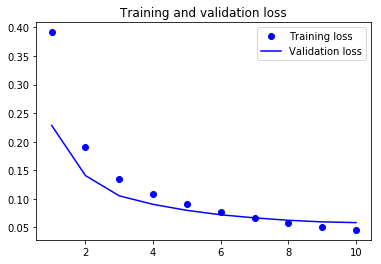

In [10]:
## Fit the model
phonorm.fit([encoder_in_ohe, decoder_in_ohe], decoder_out_ohe, batch_size = 128, epochs = 10)

In [27]:
# Predct
phonorm.predict("axiom"), phonorm.predict("aksiom")

('/"aks.I.@m/', '/"{k.sI.@m/')

In [10]:
# Save model
phonorm.save("models/wiktionary/wiktionary_model_10EP_H512")

C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'concatenate_1_1/concat:0' shape=(?, 1024) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [63]:
phonorm.history

In [6]:
## Try
phonorm = Seq2Seq(512, input_lang, output_lang)
phonorm.load("models/wiktionary/wiktionary_model_10EP_H512")

## Evaluate the model on generic dev set

The model should perform well in terms of [BLEU score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/). This is a measure of 'skill' for the model.

In [9]:
# Load dev set
devpairs = np.load("data/preprocessed/wikt2pron_dev.npy")

In [10]:
# Make predictions
inWords = [pair[0] for pair in devpairs]
outWords = [pair[1] for pair in devpairs]

In [11]:
bs_out = []
preds = []
for i, (inw, outw) in enumerate(devpairs):
    
    # Predict pronunciation
    pred = phonorm.predict(inw)
    preds.append(pred)
    
    # Print if random number > 0.99
    if random.random() > 0.99:
        ## Print
        print("--- Sample " + str(i))
        print("Word: " + inw)
        print("Ref: " + outw.replace(" ", "").replace("\n", "").replace("\t", ""))
        print("Pred: " + pred)
        print("\n")
    ## Calculate bleu score
    bs_out.append(evaluate_bleu(outw.replace(" ", "").replace("\n", "").replace("\t", ""), pred))


C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram or

--- Sample 130
Word: capsize
Ref: /k{p"saIz/
Pred: /"k{psaIz/


--- Sample 285
Word: plasmodium
Ref: /plaz"m@UdI@m/
Pred: /pl{z"moUdi.@m/




In [12]:
# Bleu score
bs_1 = [bs[0].tolist()[0] for bs in bs_out]
bs_2 = [bs[1].tolist()[0] for bs in bs_out]
bs_3 = [bs[2].tolist()[0] for bs in bs_out]
bs_4 = [bs[3].tolist()[0] for bs in bs_out]

In [13]:
import matplotlib.pyplot as plt

## Plot bleu score function
def plot_bleu(data, index = 1):
    
    #%matplotlib inline
    plt.hist(data, normed=True, bins=15)
    plt.ylabel('BLEU score')
    plt.show()

1-grams avg: 0.85
2-grams avg: 0.75
3-grams avg: 0.67
4-grams avg: 0.58


C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


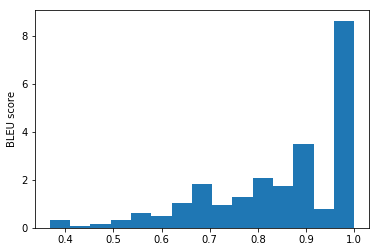

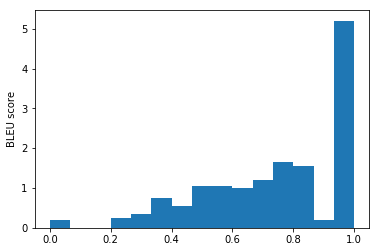

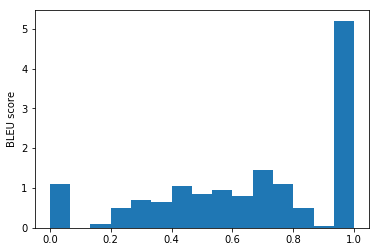

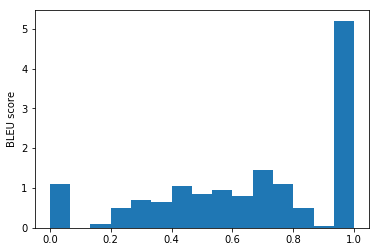

In [14]:
print("1-grams avg: " + str(np.round(np.mean(bs_1),decimals=2)))
print("2-grams avg: " + str(np.round(np.mean(bs_2),decimals=2)))
print("3-grams avg: " + str(np.round(np.mean(bs_3),decimals=2)))
print("4-grams avg: " + str(np.round(np.mean(bs_4),decimals=2)))
plot_bleu(bs_1, 1)
plot_bleu(bs_2, 2)
plot_bleu(bs_3, 3)
plot_bleu(bs_3, 4)

In [15]:
## Are there words that are predicted to be the same but are not in actuality
from collections import Counter
c = Counter(preds)

## Is the sum of the predicted frequencies shorter than the dev set?
## If so, then there are duplicates.
## This is an issue because we know that the dev set has homophones
sum(c.values()) == len(devpairs)

True

In [16]:
## Save data
import pandas as pd
print("In: " + str(len(inWords)))
print("Out: " + str(len(outWords)))
print("Pred: " + str(len(preds)))
print("BS1: " + str(len(bs_1)))
print("BS2: " + str(len(bs_2)))
print("BS3: " + str(len(bs_3)))
print("BS4: " + str(len(bs_4)))

# To dict
data_dev = {
    "in":inWords,
    "out":outWords,
    "pred":preds,
    "bs1":bs_1,
    "bs2":bs_2,
    "bs3":bs_3,
    "bs4":bs_4
}

# To pandas df
data_dev = pd.DataFrame.from_dict(data_dev)

# To csv
data_dev.to_csv("writeup/xsampa_dev.csv")

In: 300
Out: 300
Pred: 300
BS1: 300
BS2: 300
BS3: 300
BS4: 300


In [7]:
## Check out homophones set
devhmp = np.load("data/preprocessed/wikt2pron_homophone_dev.npy")

In [8]:
## Get unique pronunciations
unique_pronuns = []
for hmp in devhmp:
    if hmp[1] in unique_pronuns:
        continue
    else:
        unique_pronuns.append(hmp[1])
        
print("Unique pronunciations: " + str(len(unique_pronuns)))
print("Homophones dev entries: " + str(len(devhmp)))

Unique pronunciations: 81
Homophones dev entries: 172


In [9]:
equality = []
difficulty = []
inwords = []
outw = []
outw_pred = []
props_comp_to_outcome = []
props_comp_to_hmphones = []
props_all_equal = []
## For each unique pronunciation, predict
for pronun in unique_pronuns:
    
    ## Get entries where pronunciation is pronun
    pronun_entries_tmp = [entry for entry in devhmp if entry[1] == pronun]
    
    if len(pronun_entries_tmp) < 2:
        continue
    else:
        pronun_entries = pronun_entries_tmp
        
    ## Calculate equality score
    out_ref = pronun.replace(" ", "").replace("\t", "").replace("\n", "")
    
    ## Predict inwords
    out_pred = [phonorm.predict(pronun_entry[0]) for pronun_entry in pronun_entries]
    
    ## Add to list
    inwords.append("; ".join([inw[0] for inw in pronun_entries_tmp]))
    outw.append(out_ref)
    outw_pred.append("; ".join(out_pred))
    
    ## Equal to out?
    comp = [pred == out_ref for pred in out_pred]
    equality.append(comp)
    
    ## Proportion correct
    ## NB. also count instances where all entries are wrong but the same
    props_comp_to_outcome.append(np.sum(comp) / len(comp))
    
    ## Keep track of scores in a slighly different way --> look how many of the subgroups are equal to one another
    scores = []
    for grp in np.unique(out_pred):
        scores.append(np.sum([True if pr == grp else False for pr in out_pred]))
    
    props_comp_to_hmphones.append(scores[np.argmax(scores)] / sum(scores))
    
    ## All equal
    props_all_equal.append(int(np.all(comp)))
    
    ## If proportion low, then add to difficult
    if (np.sum(comp) / len(comp)) < 0.8:
        
        difficulty.append(
            {"ref":out_ref,
            "pred":out_pred,
            "inw":[entry[0] for entry in pronun_entries]}
        )

In [10]:
print("Equal to outcome: " + str(np.round(np.mean(props_comp_to_outcome), decimals=2)))
print("Highest subgroup: " + str(np.round(np.mean(props_comp_to_hmphones), decimals=2)))
print("All equal: " + str(np.round(np.sum(props_all_equal) / len(props_all_equal), decimals=2)))

Equal to outcome: 0.62
Highest subgroup: 0.8
All equal: 0.48


In [11]:
## Print
for i, difficult in enumerate(difficulty):
    
    print("----- Example " + str(i))
    print("Input: " + ", ".join(difficult["inw"]))
    print("Pred:  " + ", ".join(difficult["pred"]))
    print("True:  " + difficult["ref"])
    print("\n")

----- Example 0
Input: ab, abb
Pred:  /Ab/, /{b/
True:  /{b/


----- Example 1
Input: few, feu, phew
Pred:  /fju:/, /fju:/, /"fju:.i/
True:  /fju:/


----- Example 2
Input: coin, quoin, coign
Pred:  /kOIn/, /"kwi:Qn/, /kOIn/
True:  /kOIn/


----- Example 3
Input: flee, flea
Pred:  /fli:/, /"fli:@/
True:  /fli:/


----- Example 4
Input: flew, flu, flue
Pred:  /"flu:/, /flVb/, /flu:/
True:  /flu:/


----- Example 5
Input: femme, fem
Pred:  /"fEm/, /fEm/
True:  /fEm/


----- Example 6
Input: masque, masc
Pred:  /mA:sk/, /m{sk/
True:  /m{sk/


----- Example 7
Input: breast, brest
Pred:  /br\i:st/, /br\Est/
True:  /br\Est/


----- Example 8
Input: bath, bath
Pred:  /b{T/, /b{T/
True:  /bA:T/


----- Example 9
Input: marathon, marathon
Pred:  /"mar\@tQn/, /"mar\@tQn/
True:  /"m{r\@T@n/


----- Example 10
Input: gaul, gall
Pred:  [gO:l], /gO:l/
True:  /gO:l/


----- Example 11
Input: liar, lyre, lier
Pred:  /"laI@/, /laI@(r\)/, /"lI@/
True:  /"laI.@/


----- Example 12
Input: sow, sough
Pred:

In [12]:
# To pandas dataframe
import pandas as pd

data_dev_hmp = {
    "in":inwords,
    "pred": outw_pred,
    "out":outw,
    "equality":equality,
    "props_comp_to_outcome":props_comp_to_outcome,
    "props_comp_to_hmphones":props_comp_to_hmphones,
    "props_all_equal":props_all_equal
}

# To pandas df
data_dev = pd.DataFrame.from_dict(data_dev_hmp)

# To csv
data_dev.to_csv("writeup/xsampa_dev_hmp.csv")

### Misspelled words data

In [13]:
## Load data
misp = np.load('data/preprocessed/wikipedia_misspelled.npy')

In [14]:
badpreds = []
goodpreds = []
tp = 0
fp = 0
tn = 0
fn = 0
wrong = []
for (pair, score) in misp:
    
    # Predict pronunciation
    try:
        bpred = phonorm.predict(pair[0])
        gpred = phonorm.predict(pair[1])
    except:
        continue
    
    badpreds.append(bpred)
    goodpreds.append(gpred)
    
    # If bpred and gpred are the same and score == 1 (pronunciation of the words is the same), then add to accuracy
    if bpred == gpred:
        are_equal = True
    else:
        are_equal = False
    
    if score == 0:
        if are_equal == False:
            tn += 1
        else:
            fn += 1
            wrong.append([pair, bool(score), [bpred, gpred], True])
    else:
        if are_equal:
            tp += 1
        else:
            fp += 1
            wrong.append([pair, bool(score), [bpred, gpred], False])
    
    # Print if random number > 0.99
    if random.random() > 0.5:
        ## Print
        print("----------")
        print("Misspelled: " + pair[0] + ", Pred: " + bpred)
        print("Correct: " + pair[1] + ", Pred: " + gpred)
        print("\n")

----------
Misspelled: impecabbly, Pred: /Im"pEk@b@li/
Correct: impeccably, Pred: /Im"pEk@b@li/


----------
Misspelled: harasment, Pred: /"h{r\@zm@nt/
Correct: harassment, Pred: /"h{r\@sm@nt/


----------
Misspelled: casued, Pred: /"keIsId/
Correct: caused, Pred: /kOzd/


----------
Misspelled: carryng, Pred: /"kEr\IN/
Correct: carrying, Pred: /"kEr\IIN/


----------
Misspelled: fullfilled, Pred: /"fUl%fIld/
Correct: fulfilled, Pred: /fVl"fIld/


----------
Misspelled: activly, Pred: /"{k.tI.vli/
Correct: actively, Pred: /@"kIt.li/


----------
Misspelled: helment, Pred: /"hElm@nt/
Correct: helmet, Pred: /"hElmIt/


----------
Misspelled: seperatism, Pred: /"sEp@r\eItIz@m/
Correct: separatism, Pred: /"sEp@r\eItIz@m/


----------
Misspelled: likelyhood, Pred: /"laIklihUd/
Correct: likelihood, Pred: /"laIklihUd/


----------
Misspelled: druming, Pred: /"dr\u:mIN/
Correct: drumming, Pred: /"dr\VmIN/


----------
Misspelled: ceromony, Pred: /"sEr\@m@ni/
Correct: ceremony, Pred: /"sEr\Im@n

In [15]:
# Metrics
acc = (tp + tn) / (tp + fp + tn + fn)
sens = tp / (tp + fn)
spec = tn / (fn + tn)
f1 = 2*(sens * spec) / (sens + spec)
#-----

print("Accuracy: " + str(acc))
print("Sensitivity: " + str(sens))
print("Specificity: " + str(spec))
print("F1: " + str(f1))

Accuracy: 0.8484848484848485
Sensitivity: 0.8571428571428571
Specificity: 0.926829268292683
F1: 0.890625


In [16]:
wrong

[[['fullfilled', 'fulfilled'], True, ['/"fUl%fIld/', '/fVl"fIld/'], False],
 [['activly', 'actively'], True, ['/"{k.tI.vli/', '/@"kIt.li/'], False],
 [['ceromony', 'ceremony'], True, ['/"sEr\\@m@ni/', '/"sEr\\Im@ni/'], False],
 [['alledge', 'allege'], False, ['/@"lEdZ/', '/@"lEdZ/'], True],
 [['rebiulding', 'rebuilding'],
  False,
  ['/r\\I"bIlbIN/', '/r\\I"bIlbIN/'],
  True],
 [['compulsery', 'compulsory'],
  True,
  ['/k@m"pVl@r\\i/', '/k@m"pVl.t@r\\.i/'],
  False],
 [['opression', 'oppression'], False, ['/@"pr\\ES@n/', '/@"pr\\ES@n/'], True],
 [['comback', 'comeback'], True, ['/"kQm.b{k/', '/"koUm.b{k/'], False],
 [['irrelevent', 'irrelevant'],
  True,
  ['/I"r\\i:l@nt/', '/I"r\\i:l@n@nt/'],
  False],
 [['abbout', 'about'], True, ['/"{b.bu:t/', '/@"baUt/'], False]]